# Handwritten digits reckognition *(work in progress)*

In this notebook, we train a few simple models to reckognize handwritten digits. These models are not particularly efficient, but may serve as illustrations of what simple machine learning aproaches can do.

## Load and pre-process the data

We will work with the [UCI handwritten digits dataset](https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits), consisting in 1797 images with 8 by 8 pixels each. These images are pictures of digits hand-written by 43 different people. We import it using scikit-learn:

In [1]:
from sklearn.datasets import load_digits
handwritten_numbers = load_digits()

Extract the images and labels:

In [2]:
images = handwritten_numbers['images']
labels = handwritten_numbers['target']

Let us plot a few images:

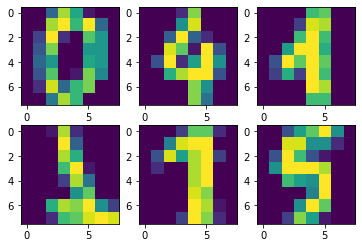

In [3]:
# import pyplot
import matplotlib.pyplot as plt

# indices of the images to plot
indices_to_plot = [[0, 100, 200],
                 [1000, 1500, 1700]]

# create the figure
fig, axes = plt.subplots(len(indices_to_plot), len(indices_to_plot[0]))
for i, l in enumerate(indices_to_plot):
    for j, im in enumerate(l):
        axes[i,j].imshow(images[im])

# show the figure        
plt.show()

Let us now normalize the images by subtracting the minimum value of all pixels and dividincg by the maximum value, so that all valueues are betweeb 0 and 1:

In [4]:
def normalize(images):
    return (images-images.min()) / (images.max()-images.min())

images = normalize(images)

Let us also print the first 100 labels:

In [5]:
print(labels[:100])

[0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 9 5 5 6 5 0
 9 8 9 8 4 1 7 7 3 5 1 0 0 2 2 7 8 2 0 1 2 6 3 3 7 3 3 4 6 6 6 4 9 1 5 0 9
 5 2 8 2 0 0 1 7 6 3 2 1 7 4 6 3 1 3 9 1 7 6 8 4 3 1]


The images do not seem to be in any particular order. 
There is thus no need to shuffle them. 
(In a real-world project, this assertion would need to be supported by stronger arguments, for instance a precise statistcal analysis of the distribution of labels, or the data should be shuffled anyway.)
Finally, we split the data into a training set and a test set, the later containing approximately 20% of the data. 

In [6]:
from numpy.random import choice
from numpy import array

# fraction of images used for the test
fraction_test = 0.2

# total number of images
n_images = images.shape[0]

# indices of the test set
indices_test = choice(range(n_images), size=int(fraction_test*n_images), replace=False)

# test set
Xtest = array([images[i] for i in indices_test]) 
Ytest = array([labels[i] for i in indices_test]) 

# train set
Xtrain = array([images[i] for i in range(n_images) if i not in indices_test]) 
Ytrain = array([labels[i] for i in range(n_images) if i not in indices_test]) 

## K-nearest neighbours

The first algorithm we use is the k-nearest neighbours, using the `KNeighborsClassifier` class from scikit-learn. 
We first define a function to train such a model:

In [7]:
# import the KNeighborsClassifier class
from sklearn.neighbors import KNeighborsClassifier

def train_knn(k, X, Y, **kwargs):
    '''
    Train a k-nearest neighbours model and return it. 
    
    Arguments:
        k (int): number of neighbours
        X (array): train data
        Y (array): train labels
        kwargs: keywords arguments for the KNeighborsClassifer instance
    '''
    
    # flatten each image
    X = array([x.flatten() for x in X])
    
    model = KNeighborsClassifier(n_neighbors=k, **kwargs)
    model.fit(X, Y)
    return model

We then define a function to test the model:

In [8]:
def test_knn(model, X, Y):
    '''
    Test a k-nearest neighbours model and return its accuracy.
    
    Arguments:
        model (KNeighborsClassifer): the model
        X (array): test data
        Y (array): test labels
    '''
    
    # flatten each image
    X = array([x.flatten() for x in X])
    
    return model.score(X, Y)

Finally, we define a function performing n-fold cross-validation:

In [9]:
from numpy.random import shuffle
from numpy import ceil, concatenate

def crossVal(n, train_function, test_function, params, X, Y, **kwargs):
    '''
    Perform an n-fold cross-validation and return the men accuracy.
    
    Arguments: 
        n (int)
        train_function (function): must take as arguments the parameter(s), 
            train data, and train labels
        test_function (function): must take as arguments the model, test data, 
            and test labels, and return the accuracy
        params (iterable): parameters for the model
        X (array): train data
        Y (array): train labels
        kwargs: keyword arguments for the model
    '''
    
    # number of elements per subset
    n_els = int(ceil(len(Y)/n))
    
    # divide the data into n (approximately) equal subsets
    indices_shuffled = array(range(len(Y)))
    shuffle(indices_shuffled)
    X_divided = [X[indices_shuffled[i*n_els:(i+1)*n_els]] for i in range(n-1)]
    X_divided.append(X[indices_shuffled[(n-1)*n_els:-1]])
    Y_divided = [Y[indices_shuffled[i*n_els:(i+1)*n_els]] for i in range(n-1)]
    Y_divided.append(Y[indices_shuffled[(n-1)*n_els:-1]])
    
    # compute the accuracy for each fold
    
    accuracy = []
    for i in range(n):
        
        # build the train and test data
        X_train = concatenate([X_divided[j] for j in range(n) if j != i])
        Y_train = concatenate([Y_divided[j] for j in range(n) if j != i])
        X_test = X_divided[i]
        Y_test = Y_divided[i]
        
        # train a model
        model = train_function(*params, X_train, Y_train, **kwargs)
        
        # compute its accuracy
        accuracy.append(test_function(model, X_test, Y_test))
        
    # return the mean value of the accuracy
    return array(accuracy).mean()

Let us plot the average accuracy for several values of $k$ for $n=4$: 

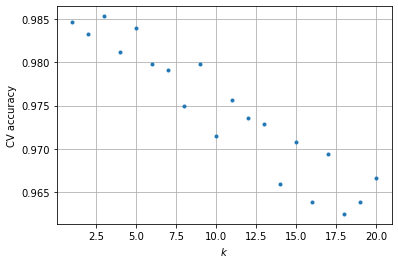

In [10]:
list_k = range(1,21)

acc = [crossVal(4, train_knn, test_knn, (k,), Xtrain, Ytrain) for k in list_k]

plt.plot(list_k, acc, r'.')
plt.grid()
plt.xlabel('$k$')
plt.ylabel('CV accuracy')
plt.show()

It seems that models with a relatively small value of $k$ give the best results. 
let us train and test a model with $k=3$:

In [11]:
k = 3
model = train_knn(k, Xtrain, Ytrain)
test_knn(model, Xtest, Ytest)

0.9888579387186629

This model has an accuracy close to 99%.

## Perceptron with one single hidden layer

Let us now use a very simple neural network, with only one hidden layer. 
We use the `MLPClassifier` class from scikit-learn. 
We first define a function to train the model:

In [21]:
# import the MLPClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning

# decorator to suppress a convergence warning (this warning should be dealt 
# with properly in real-world applications)
@ignore_warnings(category=ConvergenceWarning)
def train_P(ks, X, Y, **kwargs):
    '''
    Train a percetron and return it. 
    
    Arguments:
        ks (list): number of neurons for each layer
        X (array): train data
        Y (array): train labels
        kwargs: keywords arguments for the MLPClassifier instance
    '''
    
    # flatten each image
    X = array([x.flatten() for x in X])
    
    model = MLPClassifier(hidden_layer_sizes=k, **kwargs)
    model.fit(X, Y)
    return model

Let us use cross-validation woth $n=4$ to select the optimal number of neurons:

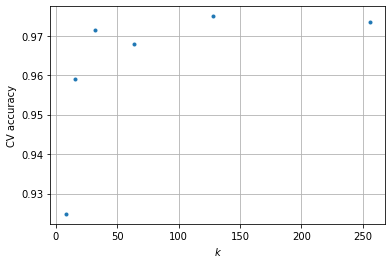

In [14]:
list_k = [8, 16, 32, 64, 128, 256]

acc = [crossVal(4, train_P, test_knn, (k,), Xtrain, Ytrain) for k in list_k]

plt.plot(list_k, acc, r'.')
plt.grid()
plt.xlabel('$k$')
plt.ylabel('CV accuracy')
plt.show()

It seems that the best-performing model is the one with 128 neurons. 
Let us see how it performs: 

In [18]:
model = train_P(128, Xtrain, Ytrain)
test_knn(model, Xtest, Ytest)

0.9805013927576601

This model has a testa ccuracy close to 98%. 

Let us plot the train and test accuracies of each model to see which of them overfits or underfits:

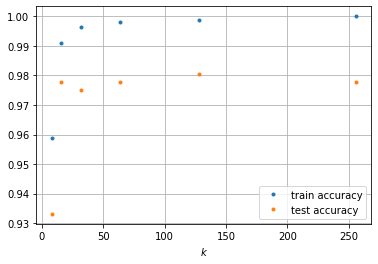

In [16]:
train_acc = []
test_acc = []

for k in list_k:
    model = train_1P(k, Xtrain, Ytrain)
    train_acc.append(test_knn(model, Xtrain, Ytrain))
    test_acc.append(test_knn(model, Xtest, Ytest))
    
plt.plot(list_k, train_acc, r'.', label='train accuracy')
plt.plot(list_k, test_acc, r'.', label='test accuracy')
plt.legend()
plt.grid()
plt.xlabel('$k$')
plt.show()

All the models seem to overfit.

## Perceptron with multiple hidden layers

Let us now add a second hiden layer to our models.

In [28]:
list_ks = [(2,2), (3,3), (2,4), (4,2), (4,4), (8,8), (4,12), (12,4), (16,16), (32,32), (64,64)]

for ks in list_ks: 
    print('Shape: ' + str(ks) + ', CV accuracy: ' + str(crossVal(4, train_P, test_knn, (ks,), Xtrain, Ytrain)))

Shape: (2, 2), CV accuracy: 0.9805205415499533
Shape: (3, 3), CV accuracy: 0.97218720821662
Shape: (2, 4), CV accuracy: 0.9812324929971988
Shape: (4, 2), CV accuracy: 0.9756419234360412
Shape: (4, 4), CV accuracy: 0.974953314659197
Shape: (8, 8), CV accuracy: 0.9770483193277311
Shape: (4, 12), CV accuracy: 0.9770366479925304
Shape: (12, 4), CV accuracy: 0.9735585901027077
Shape: (16, 16), CV accuracy: 0.9825863678804856
Shape: (32, 32), CV accuracy: 0.9749591503267975
Shape: (64, 64), CV accuracy: 0.9763597105508871


The best model seems to be the one with 2 neurons in the first hidden layer and 4 in the second one. 
(However, the performances of these models are very close. A more precise statistical analysys would be required to ascertain which is better.)
Let us test it: 

In [38]:
model = train_P((2,4), Xtrain, Ytrain)
test_knn(model, Xtest, Ytest)

0.9832869080779945

The accuracy is close to 98%.

Finally, let us try with 3 layers: 

In [40]:
list_ks = [(2,2,2), (2,2,4), (2,4,2), (2,4,4), (2,4,8), (8,4,2), (4,4,2), (4,2,2)]

for ks in list_ks: 
    print('Shape: ' + str(ks) + ', CV accuracy: ' + str(crossVal(4, train_P, test_knn, (ks,), Xtrain, Ytrain)))

Shape: (2, 2, 2), CV accuracy: 0.9770424836601307
Shape: (2, 2, 4), CV accuracy: 0.9784255368814193
Shape: (2, 4, 2), CV accuracy: 0.977719421101774
Shape: (2, 4, 4), CV accuracy: 0.9777427637721755
Shape: (2, 4, 8), CV accuracy: 0.97703081232493
Shape: (8, 4, 2), CV accuracy: 0.9784255368814193
Shape: (4, 4, 2), CV accuracy: 0.973546918767507
Shape: (4, 2, 2), CV accuracy: 0.972875816993464


The models with shape (2,2,4) and (8,4,2) seem to have the best performance, although the differences are again too small to be statistically significant. 
Let us test them: 

In [41]:
model = train_P((2,2,4), Xtrain, Ytrain)
print(test_knn(model, Xtest, Ytest))

model = train_P((8,4,2), Xtrain, Ytrain)
print(test_knn(model, Xtest, Ytest))

0.9805013927576601
0.9777158774373259


They both have an accuracy close to 98%. 

In summary, it seems that imple perceptron models have a slightly lower accuracy than k-nearest neighbours for this problem.

**To do:**
* **try with a random forest**
* **try with a convolutional neural network**